In [1]:
from ultralytics import YOLO
from PIL import Image
from IPython.display import display
from matplotlib import gridspec
import numpy as np
import torch
import os
import pandas as pd
import yaml
import seaborn as sn
import warnings
import random
from transformers import AutoImageProcessor, AutoModel
import matplotlib.pyplot as plt
from utils import draw_bounding_boxes

c:\Users\pedro\coding\Buscador-de-roupas\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def roi_from_bbox(image, top_left, bottom_right):
    x1, y1 = top_left
    x2, y2 = bottom_right

    image = np.array(image)
    mask = np.zeros(image.shape,np.uint8)
    mask[y1:y2,x1:x2] = image[y1:y2,x1:x2]
    mask = Image.fromarray(mask)

    return mask

def hstack_images(images):
    imgs_comb = np.hstack([i.resize((224, 224)) for i in images])
    out_img = Image.fromarray(imgs_comb)

    return out_img

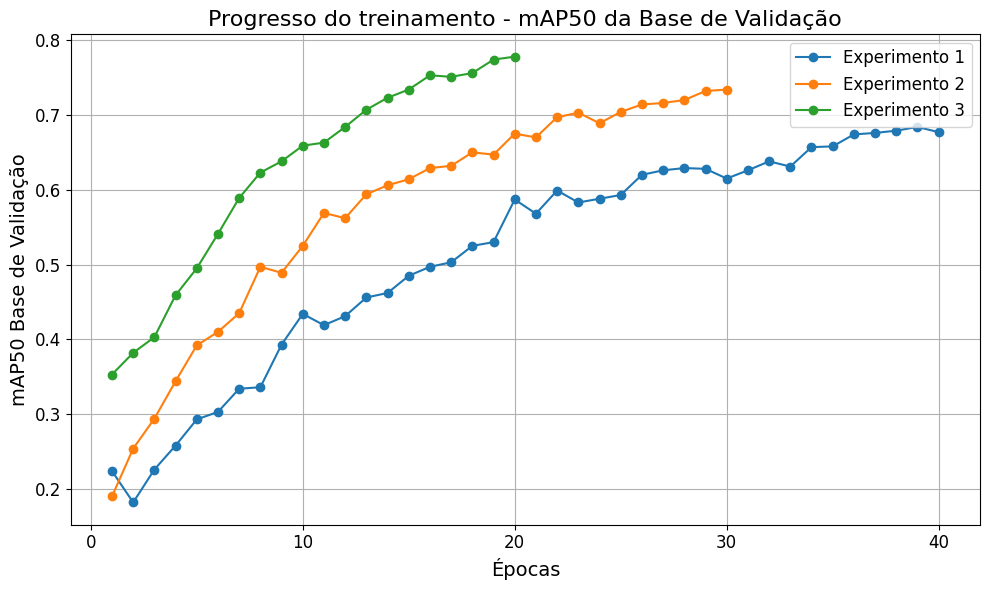

In [3]:
experiment_1_mAP50 = [0.224, 0.182, 0.226, 0.258, 0.293, 0.303, 0.334, 0.336, 0.393, 0.434,
                      0.419, 0.431, 0.456, 0.462, 0.485, 0.497, 0.503, 0.525, 0.53, 0.587, 0.568,
                      0.599, 0.583, 0.588, 0.593, 0.62, 0.626, 0.629, 0.628, 0.615, 0.626, 0.638, 0.631, 0.657, 0.658, 0.674, 0.676, 0.679, 0.684, 0.677]

experiment_2_mAP50 = [0.19, 0.254, 0.294, 0.344, 0.392, 0.41, 0.435, 0.497, 0.489, 0.525,
                      0.569, 0.562, 0.594, 0.606, 0.614, 0.629, 0.632, 0.65, 0.647, 0.675,
                      0.67, 0.697, 0.703, 0.689, 0.704, 0.714, 0.716, 0.72, 0.732, 0.734]

experiment_3_mAP50 = [0.353, 0.382, 0.403, 0.459, 0.495, 0.541, 0.589, 0.623, 0.638, 0.659,
                      0.663, 0.684, 0.707, 0.723, 0.734, 0.753, 0.751, 0.756, 0.774, 0.778]

epochs_1 = range(1, len(experiment_1_mAP50) + 1)
epochs_2 = range(1, len(experiment_2_mAP50) + 1)
epochs_3 = range(1, len(experiment_3_mAP50) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_1, experiment_1_mAP50, marker='o', label='Experimento 1')
plt.plot(epochs_2, experiment_2_mAP50, marker='o', label='Experimento 2')
plt.plot(epochs_3, experiment_3_mAP50, marker='o', label='Experimento 3')
plt.title('Progresso do treinamento - mAP50 da Base de Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('mAP50 Base de Validação', fontsize=14)
plt.xticks(range(0, len(experiment_1_mAP50) + 1, 10), fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [4]:
iou_thres=0.45
conf=0.25
nc=13
test = pd.read_csv(os.path.join("experiments", "experiment_3", "test_data.csv"))
YOLO_CONFIG_FILE = "yolo/config.yaml"
with open(YOLO_CONFIG_FILE, 'r') as f:
    config = yaml.safe_load(f)
    names = config.get('names', {})
    categories = {name: int(number) for number, name in names.items()}
model = YOLO('yolo/runs/detect/train4/weights/best.pt')

# code from https://github.com/ultralytics/ultralytics/blob/main/ultralytics/utils/metrics.py
matrix = np.zeros((nc + 1, nc + 1))

def box_iou(box1, box2, eps=1e-7):
    """
    Calculate intersection-over-union (IoU) of boxes. Both sets of boxes are expected to be in (x1, y1, x2, y2) format.
    Based on https://github.com/pytorch/vision/blob/master/torchvision/ops/boxes.py

    Args:
        box1 (torch.Tensor): A tensor of shape (N, 4) representing N bounding boxes.
        box2 (torch.Tensor): A tensor of shape (M, 4) representing M bounding boxes.
        eps (float, optional): A small value to avoid division by zero. Defaults to 1e-7.

    Returns:
        (torch.Tensor): An NxM tensor containing the pairwise IoU values for every element in box1 and box2.
    """

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)


def process_batch(detections, gt_bboxes, gt_cls):
    """
    Update confusion matrix for object detection task.

    Args:
        detections (Array[N, 6] | Array[N, 7]): Detected bounding boxes and their associated information.
                                    Each row should contain (x1, y1, x2, y2, conf, class)
                                    or with an additional element `angle` when it's obb.
        gt_bboxes (Array[M, 4]| Array[N, 5]): Ground truth bounding boxes with xyxy/xyxyr format.
        gt_cls (Array[M]): The class labels.
    """
    global matrix
    if gt_cls.shape[0] == 0:  # Check if labels is empty
        if detections is not None:
            detections = detections[detections[:, 4] > conf]
            detection_classes = detections[:, 5]
            for dc in detection_classes:
                matrix[dc, nc] += 1  # false positives
        return
    if detections is None:
        gt_classes = gt_cls.int()
        for gc in gt_classes:
            matrix[nc, gc] += 1  # background FN
        return

    detections = detections[detections[:, 4] > conf]
    gt_classes = gt_cls.int()
    detection_classes = detections[:, 5].int()
    iou = (
        box_iou(gt_bboxes, detections[:, :4])
    )

    x = torch.where(iou > iou_thres)
    if x[0].shape[0]:
        matches = torch.cat((torch.stack(x, 1), iou[x[0], x[1]][:, None]), 1).cpu().numpy()
        if x[0].shape[0] > 1:
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
            matches = matches[matches[:, 2].argsort()[::-1]]
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
    else:
        matches = np.zeros((0, 3))

    n = matches.shape[0] > 0
    m0, m1, _ = matches.transpose().astype(int)
    for i, gc in enumerate(gt_classes):
        j = m0 == i
        if n and sum(j) == 1:
            matrix[detection_classes[m1[j]], gc] += 1  # correct
        else:
            matrix[nc, gc] += 1  # true background

    if n:
        for i, dc in enumerate(detection_classes):
            if not any(m1 == i):
                matrix[dc, nc] += 1  # predicted background


"""
Plot the confusion matrix using seaborn and save it to a file.

Args:
    normalize (bool): Whether to normalize the confusion matrix.
    save_dir (str): Directory where the plot will be saved.
    names (tuple): Names of classes, used as labels on the plot.
    on_plot (func): An optional callback to pass plots path and data when they are rendered.
"""

for image in test['image_filename'].unique():
    image_data = test[test['image_filename'] == image]

    gt_bboxes = torch.tensor([[row['xmin'], row['ymin'], row['xmax'], row['ymax']] for idx, row in image_data.iterrows()])
    gt_cls = torch.tensor([categories[row['category_name']] for idx, row in image_data.iterrows()])

    source_img = os.path.join('deepfashion2', 'train', 'image', image)
    results = model(source_img)[0].to('cpu')

    preds = []

    for bbox, category in zip(results.boxes.xyxy, results.boxes.cls):
        bbox_info = torch.zeros(6)
        bbox_info[:4] = bbox
        bbox_info[4] = 1.0
        bbox_info[5] = category
        preds.append(bbox_info.unsqueeze(0))

    if preds:
        preds = torch.cat(preds, dim=0)
    else:
        preds = None
    
    process_batch(preds, gt_bboxes, gt_cls)


normalize=False
names = tuple(names[i] for i in range(len(names)))

array = matrix / ((matrix.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

fig, ax = plt.subplots(1, 1, figsize=(20, 17), tight_layout=True)
nc, nn = nc, len(names)  # number of classes, names
sn.set(font_scale=2.6 if nc < 50 else 0.8)  # for label size
labels = (0 < nn < 99) and (nn == nc)  # apply names to ticklabels
ticklabels = (list(names) + ["background"]) if labels else "auto"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
    sn.heatmap(
        array,
        ax=ax,
        annot=nc < 30,
        annot_kws={"size": 24},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

title = "Matriz de Confusão" + " Normalizada" * normalize
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previsto")
ax.set_title(title)
plot_fname = 'confusion_matrix.png'
fig.savefig(plot_fname, dpi=250)
plt.close(fig)


image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000133.jpg: 640x480 1 short_sleeve_top, 1 trousers, 1 vest, 52.8ms
Speed: 11.0ms preprocess, 52.8ms inference, 48.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000299.jpg: 448x640 1 trousers, 1 short_sleeve_dress, 1 long_sleeve_dress, 45.0ms
Speed: 2.2ms preprocess, 45.0ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000411.jpg: 640x512 1 short_sleeve_top, 1 shorts, 41.0ms
Speed: 3.0ms preprocess, 41.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000696.jpg: 640x448 1 trousers, 1 long_sleeve_top, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 c:\Users\pedro\coding\Busca

In [7]:
normalize=True
names = tuple(names[i] for i in range(len(names)))

array = matrix / ((matrix.sum(0).reshape(1, -1) + 1e-9) if normalize else 1)  # normalize columns
array[array < 0.005] = np.nan  # don't annotate (would appear as 0.00)

fig, ax = plt.subplots(1, 1, figsize=(20, 17), tight_layout=True)
nc, nn = nc, len(names)  # number of classes, names
sn.set(font_scale=2.6 if nc < 50 else 0.8)  # for label size
labels = (0 < nn < 99) and (nn == nc)  # apply names to ticklabels
ticklabels = (list(names) + ["background"]) if labels else "auto"
with warnings.catch_warnings():
    warnings.simplefilter("ignore")  # suppress empty matrix RuntimeWarning: All-NaN slice encountered
    sn.heatmap(
        array,
        ax=ax,
        annot=nc < 30,
        annot_kws={"size": 24},
        cmap="Blues",
        fmt=".2f" if normalize else ".0f",
        square=True,
        vmin=0.0,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    ).set_facecolor((1, 1, 1))

title = "Matriz de Confusão" + " Normalizada" * normalize
ax.set_xlabel("Verdadeiro")
ax.set_ylabel("Previsto")
ax.set_title(title)
plot_fname = 'confusion_matrix_normalized.png'
fig.savefig(plot_fname, dpi=250)
plt.close(fig)

### código para encontrar casos errados

In [8]:
array[np.isnan(array)] = 0
flat_confusion_matrix = [(array[i][j], ticklabels[i], ticklabels[j]) for i in range(len(array)) for j in range(len(array[0])) if i != j]

sorted_confusion_matrix = sorted(flat_confusion_matrix, key=lambda x: x[0], reverse=True)

top_5_highest = sorted_confusion_matrix[:4]

for i, (value, predicted_class, true_class) in enumerate(top_5_highest, start=1):
    print(f"Rank {i}: Categoria verdadeira '{true_class}' predito como '{predicted_class}' com valor {round(value, 2)}")

Rank 1: Categoria verdadeira 'short_sleeve_outwear' predito como 'long_sleeve_outwear' com valor 0.17
Rank 2: Categoria verdadeira 'background' predito como 'short_sleeve_top' com valor 0.14
Rank 3: Categoria verdadeira 'vest_dress' predito como 'sling_dress' com valor 0.13
Rank 4: Categoria verdadeira 'vest' predito como 'background' com valor 0.12


In [39]:
pred_class = 'background'
gt_class = 'vest'
categories['background'] = 13
images = []
for image in test['image_filename'].unique():
    image_data = test[test['image_filename'] == image]

    gt_bboxes = torch.tensor([[row['xmin'], row['ymin'], row['xmax'], row['ymax']] for idx, row in image_data.iterrows()])
    gt_cls = torch.tensor([categories[row['category_name']] for idx, row in image_data.iterrows()])

    source_img = os.path.join('deepfashion2', 'train', 'image', image)
    results = model(source_img)[0].to('cpu')

    preds = []

    for bbox, category in zip(results.boxes.xyxy, results.boxes.cls):
        bbox_info = torch.zeros(6)
        bbox_info[:4] = bbox
        bbox_info[4] = 1.0
        bbox_info[5] = category
        preds.append(bbox_info.unsqueeze(0))

    if preds:
        preds = torch.cat(preds, dim=0)
    else:
        preds = None
    
    matrix = np.zeros((nc + 1, nc + 1))
    process_batch(preds, gt_bboxes, gt_cls)
    if matrix[categories[pred_class]][categories[gt_class]] > 0: images.append(image)


image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000133.jpg: 640x480 1 short_sleeve_top, 1 trousers, 1 vest, 366.0ms
Speed: 4.0ms preprocess, 366.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000299.jpg: 448x640 1 trousers, 1 short_sleeve_dress, 1 long_sleeve_dress, 33.0ms
Speed: 2.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000411.jpg: 640x512 1 short_sleeve_top, 1 shorts, 35.0ms
Speed: 2.0ms preprocess, 35.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\000696.jpg: 640x448 1 trousers, 1 long_sleeve_top, 33.0ms
Speed: 2.0ms preprocess, 33.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 c:\Users\pedro\coding\Busca

In [40]:
images

['002251.jpg',
 '009130.jpg',
 '033325.jpg',
 '039812.jpg',
 '043429.jpg',
 '062208.jpg',
 '068971.jpg',
 '076792.jpg',
 '091074.jpg',
 '094460.jpg',
 '099064.jpg',
 '099204.jpg',
 '100208.jpg',
 '118977.jpg',
 '121595.jpg',
 '124489.jpg',
 '127049.jpg',
 '129156.jpg',
 '129819.jpg',
 '139876.jpg',
 '140688.jpg',
 '141265.jpg',
 '148785.jpg',
 '183302.jpg',
 '186130.jpg']


image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\039812.jpg: 576x640 1 vest_dress, 246.0ms
Speed: 4.0ms preprocess, 246.0ms inference, 1.0ms postprocess per image at shape (1, 3, 576, 640)


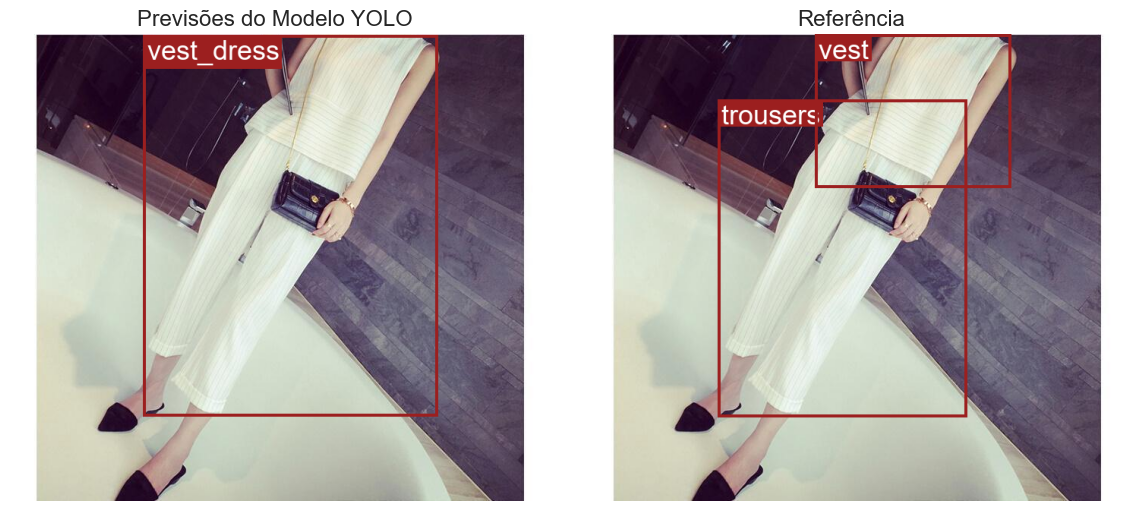

In [44]:
selected_image = '039812.jpg'

sampled_image = test[test['image_filename'] == selected_image]
image_path = sampled_image['image_filename'].iloc[0]
gt_img = f"deepfashion2/train/image/{image_path}"

gt_bboxes = [(row['xmin'], row['ymin'], row['xmax'], row['ymax']) for _, row in sampled_image.iterrows()]
gt_categories = list(sampled_image['category_name'])

gt_img_with_boxes = draw_bounding_boxes(gt_img, gt_bboxes, gt_categories)

pred_img = os.path.join('deepfashion2', 'train', 'image', selected_image)
results = model(pred_img)[0].to('cpu').numpy()

pred_bboxes = [bbox[:4] for bbox in results.boxes.xyxy]
pred_categories = [results.names[category] for category in results.boxes.cls]

pred_img_with_boxes = draw_bounding_boxes(pred_img, pred_bboxes, pred_categories)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pred_img_with_boxes)
axes[0].set_title("Previsões do Modelo YOLO", fontsize=16)
axes[0].axis("off")

axes[1].imshow(gt_img_with_boxes)
axes[1].set_title("Referência", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### exemplo de detecção


image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\031390.jpg: 640x608 1 trousers, 1 long_sleeve_top, 42.0ms
Speed: 2.0ms preprocess, 42.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 608)


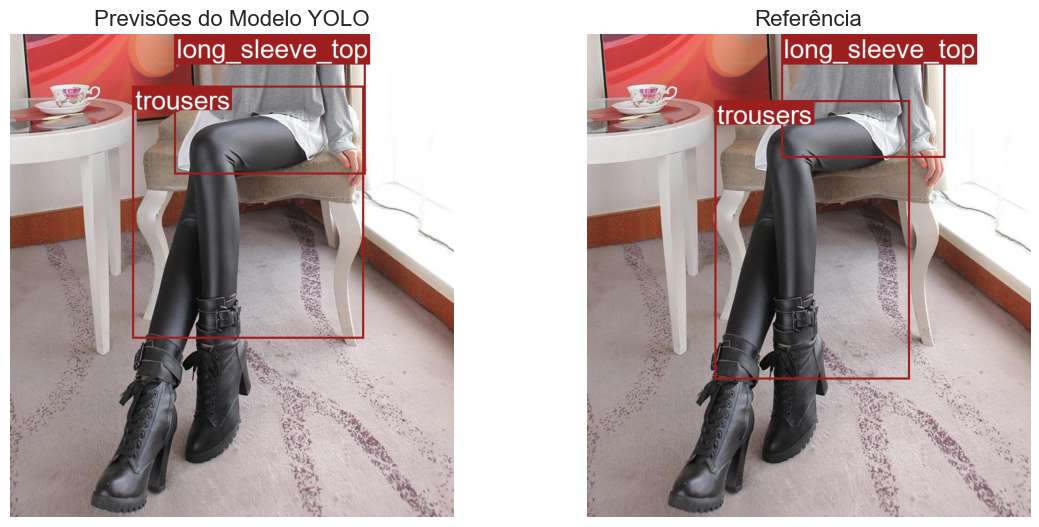

In [57]:
selected_image = random.choice(test['image_filename'].unique())

sampled_image = test[test['image_filename'] == selected_image]
image_path = sampled_image['image_filename'].iloc[0]
gt_img = f"deepfashion2/train/image/{image_path}"

gt_bboxes = [(row['xmin'], row['ymin'], row['xmax'], row['ymax']) for _, row in sampled_image.iterrows()]
gt_categories = list(sampled_image['category_name'])

gt_img_with_boxes = draw_bounding_boxes(gt_img, gt_bboxes, gt_categories)

pred_img = os.path.join('deepfashion2', 'train', 'image', selected_image)
model = YOLO('yolo/runs/detect/train4/weights/best.pt')
results = model(pred_img)[0].to('cpu').numpy()

pred_bboxes = [bbox[:4] for bbox in results.boxes.xyxy]
pred_categories = [results.names[category] for category in results.boxes.cls]

pred_img_with_boxes = draw_bounding_boxes(pred_img, pred_bboxes, pred_categories)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(pred_img_with_boxes)
axes[0].set_title("Previsões do Modelo YOLO", fontsize=16)
axes[0].axis("off")

axes[1].imshow(gt_img_with_boxes)
axes[1].set_title("Referência", fontsize=16)
axes[1].axis("off")

plt.tight_layout()
plt.show()

### busca por similaridade


image 1/1 c:\Users\pedro\coding\Buscador-de-roupas\deepfashion2\train\image\006951.jpg: 640x448 1 trousers, 1 sling, 28.0ms
Speed: 1.0ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)
['trousers', 'sling']


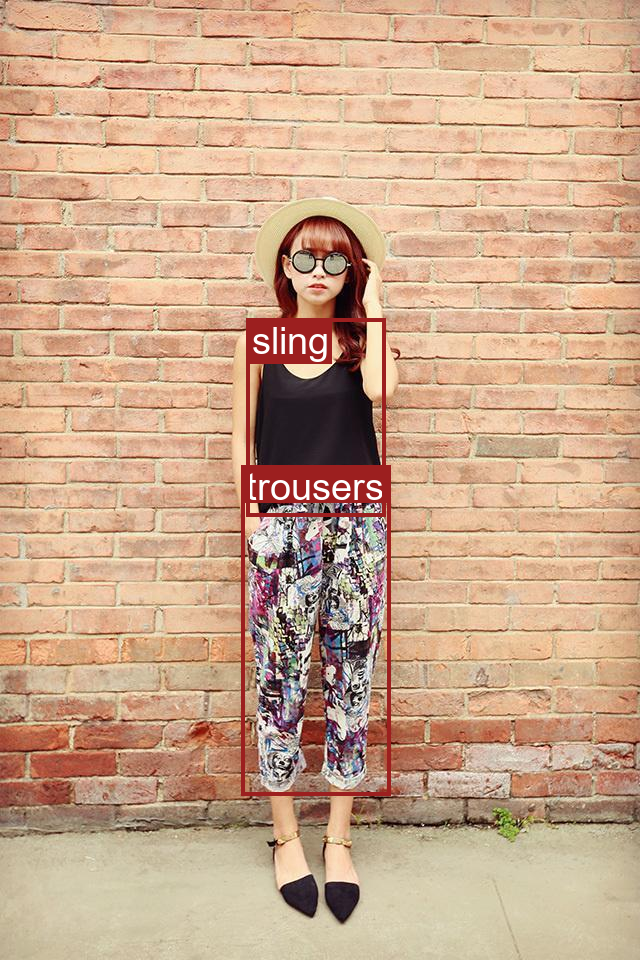

In [37]:
selected_image = random.choice(test['image_filename'].unique())
query_img_path = os.path.join('deepfashion2', 'train', 'image', selected_image)
model = YOLO('yolo/runs/detect/train4/weights/best.pt')
results = model(query_img_path)[0].to('cpu').numpy()

bboxes = [bbox[:4] for bbox in results.boxes.xyxy]
categories = [results.names[category] for category in results.boxes.cls]

img = draw_bounding_boxes(query_img_path, bboxes, categories)
print(categories)
display(img)

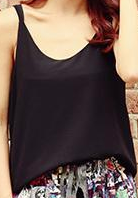

In [47]:
selected_category = 'sling'
image = Image.open(query_img_path)

for bbox, category in zip(bboxes, categories):
    xmin, ymin, xmax, ymax = bbox
    if category == selected_category:
        cropped_region = image.crop((xmin, ymin, xmax, ymax))

display(cropped_region)

In [48]:
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')

with torch.no_grad():
    inputs = processor(images=cropped_region, return_tensors="pt")
    outputs = model(**inputs)
    image_features = outputs.last_hidden_state
    output = image_features.mean(dim=1).numpy()

output.shape

(1, 768)

In [49]:
loaded_data = np.load(os.path.join(os.getcwd(), "embedding", f"{selected_category}.npz"), allow_pickle=True)
loaded_data['embeddings'].shape

(1396, 768)

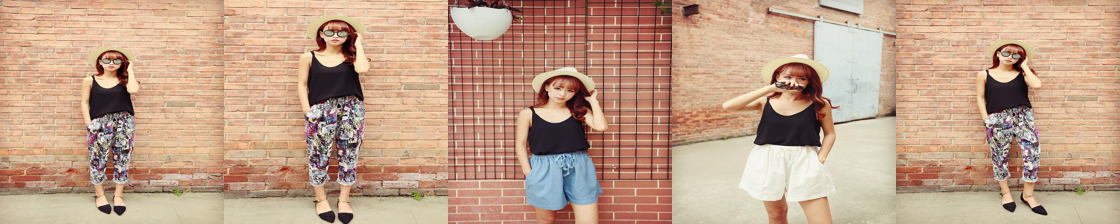

In [50]:
distances = np.linalg.norm(loaded_data['embeddings'] - output, axis=1)

k = 5
closest_indices = np.argsort(distances)[:k]
closest_distances = distances[closest_indices]
closest_embeddings = loaded_data['embeddings'][closest_indices]

imgs_paths = []
for image in loaded_data['strings'][closest_indices]:
    imgs_paths.append(os.path.join(os.getcwd(), 'deepfashion2', 'train', 'image', image))

imgs = [ Image.open(i) for i in imgs_paths ]
imgs = hstack_images(imgs)
display(imgs)

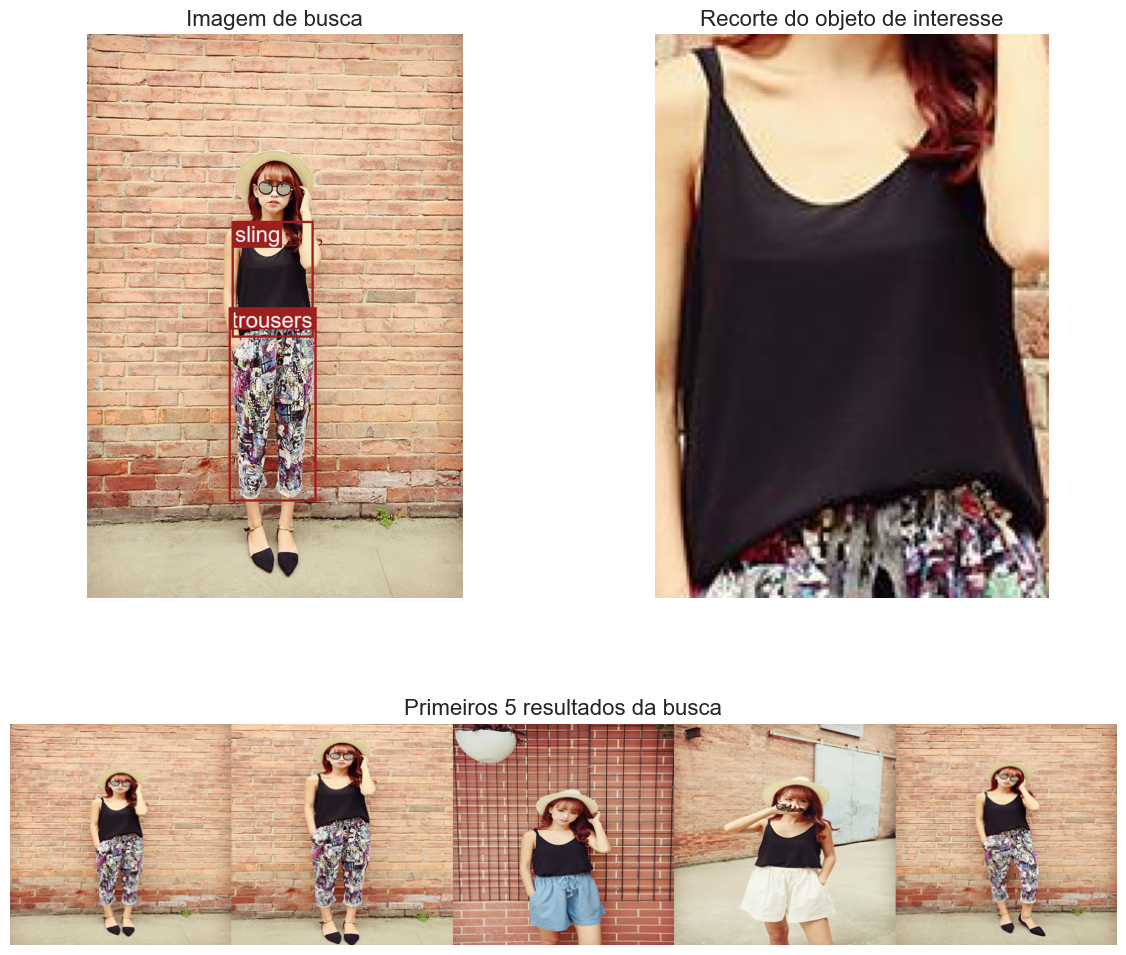

In [51]:
fig = plt.figure(figsize=(12, 12))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1], height_ratios=[1, 1])

ax_query = plt.subplot(gs[0, 0])
ax_query.imshow(img)
ax_query.set_title('Imagem de busca', fontsize=16)
ax_query.axis('off')

ax_cropped = plt.subplot(gs[0, 1])
ax_cropped.imshow(cropped_region)
ax_cropped.set_title('Recorte do objeto de interesse', fontsize=16)
ax_cropped.axis('off')

ax_results = plt.subplot(gs[1, :])
ax_results.imshow(imgs)
ax_results.set_title('Primeiros 5 resultados da busca', fontsize=16)
ax_results.axis('off')

plt.tight_layout()
plt.show()